<a href="https://colab.research.google.com/github/sreelathask1/PES_SEM4/blob/main/Sreelatha_Optimizers_Research_with_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 337kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


OscillatingLR - Epoch [1/10], Loss: 0.5335
OscillatingLR - Epoch [2/10], Loss: 0.3188
OscillatingLR - Epoch [3/10], Loss: 0.2722
OscillatingLR - Epoch [4/10], Loss: 0.2398
OscillatingLR - Epoch [5/10], Loss: 0.2164
OscillatingLR - Epoch [6/10], Loss: 0.1981
OscillatingLR - Epoch [7/10], Loss: 0.1805
OscillatingLR - Epoch [8/10], Loss: 0.1646
OscillatingLR - Epoch [9/10], Loss: 0.1478
OscillatingLR - Epoch [10/10], Loss: 0.1326
OscillatingLR Test Accuracy: 91.84%
SGD - Epoch [1/10], Loss: 0.5267
SGD - Epoch [2/10], Loss: 0.3148
SGD - Epoch [3/10], Loss: 0.2682
SGD - Epoch [4/10], Loss: 0.2391
SGD - Epoch [5/10], Loss: 0.2163
SGD - Epoch [6/10], Loss: 0.1964
SGD - Epoch [7/10], Loss: 0.1789
SGD - Epoch [8/10], Loss: 0.1628
SGD - Epoch [9/10], Loss: 0.1483
SGD - Epoch [10/10], Loss: 0.1335
SGD Test Accuracy: 91.93%
Adam - Epoch [1/10], Loss: 0.5217
Adam - Epoch [2/10], Loss: 0.3803
Adam - Epoch [3/10], Loss: 0.3510
Adam - Epoch [4/10], Loss: 0.3397
Adam - Epoch [5/10], Loss: 0.3323
Adam -

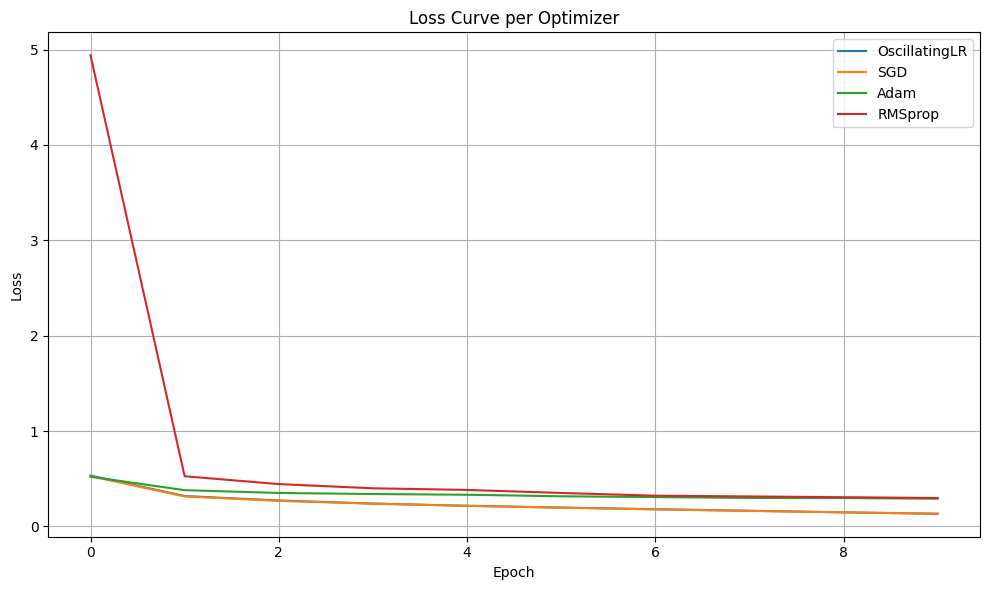


Final Accuracy Comparison:
OscillatingLR: 91.84%
SGD: 91.93%
Adam: 87.73%
RMSprop: 87.37%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Custom Optimizer with Oscillating Learning Rate and Momentum
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005,
                 momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0

        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity

        if closure is not None:
            return closure()

# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                  transform=transform,
                                                  download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                 transform=transform,
                                                 download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN for Fashion-MNIST
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train and evaluate with loss tracking
def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = FashionMNISTCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 10
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{optimizer_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'{optimizer_name} Test Accuracy: {accuracy:.2f}%')
    return accuracy, epoch_losses

# Compare optimizers
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01,
                                      "oscillation_factor": 0.005,
                                      "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}

results = {}
loss_logs = {}

for name, (opt_class, opt_params) in optimizers.items():
    acc, losses = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = acc
    loss_logs[name] = losses

# Plot loss curves
plt.figure(figsize=(10, 6))
for name, losses in loss_logs.items():
    plt.plot(losses, label=name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve per Optimizer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final comparison
print("\nFinal Accuracy Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}%")


# New Section

100%|██████████| 9.91M/9.91M [00:00<00:00, 143MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 24.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 39.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]


OscillatingLR - Epoch [1/5], Loss: 0.2092
OscillatingLR - Epoch [2/5], Loss: 0.0825
OscillatingLR - Epoch [3/5], Loss: 0.0639
OscillatingLR - Epoch [4/5], Loss: 0.0536
OscillatingLR - Epoch [5/5], Loss: 0.0470
OscillatingLR Test Accuracy: 98.27%
SGD - Epoch [1/5], Loss: 0.2027
SGD - Epoch [2/5], Loss: 0.0814
SGD - Epoch [3/5], Loss: 0.0654
SGD - Epoch [4/5], Loss: 0.0541
SGD - Epoch [5/5], Loss: 0.0476
SGD Test Accuracy: 98.10%
Adam - Epoch [1/5], Loss: 0.2333
Adam - Epoch [2/5], Loss: 0.0664
Adam - Epoch [3/5], Loss: 0.0522
Adam - Epoch [4/5], Loss: 0.0477
Adam - Epoch [5/5], Loss: 0.0416
Adam Test Accuracy: 97.86%
RMSprop - Epoch [1/5], Loss: 0.4357
RMSprop - Epoch [2/5], Loss: 0.0951
RMSprop - Epoch [3/5], Loss: 0.0585
RMSprop - Epoch [4/5], Loss: 0.0626
RMSprop - Epoch [5/5], Loss: 0.0367
RMSprop Test Accuracy: 97.76%

Final Accuracy Comparison:
OscillatingLR: 98.27%
SGD: 98.10%
Adam: 97.86%
RMSprop: 97.76%


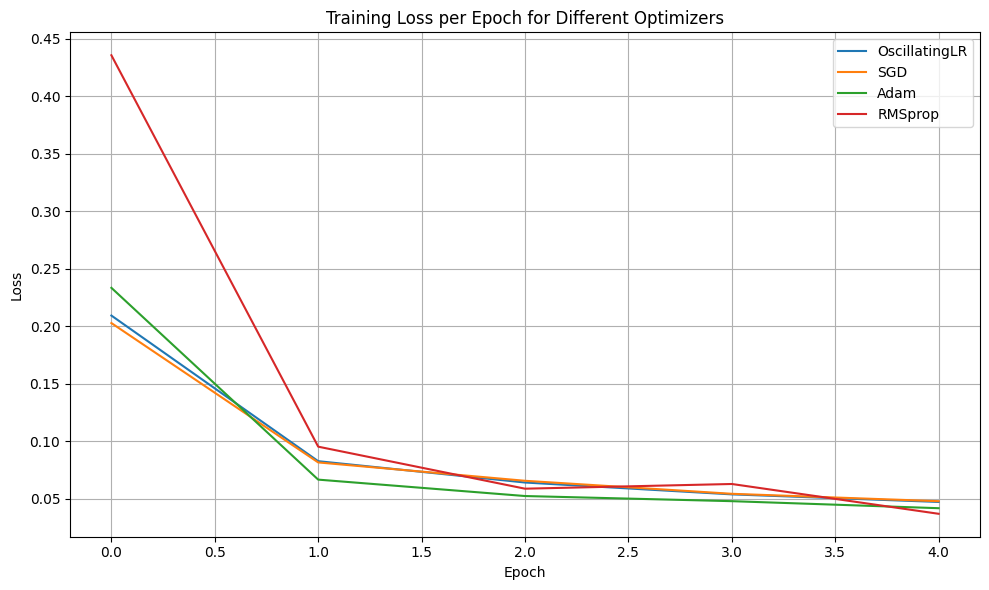

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt  # <--- Added for plotting

class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005,
                 momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0

        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity

        if closure is not None:
            return closure()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 5
    epoch_losses = []  # <--- Store losses here

    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{optimizer_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate on test data
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'{optimizer_name} Test Accuracy: {accuracy:.2f}%')
    return accuracy, epoch_losses

# Compare optimizers
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01,
                                      "oscillation_factor": 0.005}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}

results = {}
losses = {}

for name, (opt_class, opt_params) in optimizers.items():
    acc, epoch_losses = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = acc
    losses[name] = epoch_losses

# Final comparison
print("\nFinal Accuracy Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}%")

# Plot loss curves
plt.figure(figsize=(10, 6))
for name, epoch_losses in losses.items():
    plt.plot(epoch_losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch for Different Optimizers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Custom Optimizer: Oscillating Learning Rate and Momentum
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005,
                 momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count
        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity
        if closure is not None:
            return closure()

# Dataset loader
def get_dataset(name, batch_size=64):
    if name == "FashionMNIST":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
        train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                          train=True,
                                                          transform=transform,
                                                          download=True)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                         train=False,
                                                         transform=transform,
                                                         download=True)
        input_channels, num_classes = 1, 10
    elif name == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
        train_dataset = torchvision.datasets.MNIST(root='./data',
                                                   train=True,
                                                   transform=transform,
                                                   download=True)
        test_dataset = torchvision.datasets.MNIST(root='./data',
                                                  train=False,
                                                  transform=transform,
                                                  download=True)
        input_channels, num_classes = 1, 10
    elif name == "KMNIST":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
        train_dataset = torchvision.datasets.KMNIST(root='./data',
                                                    train=True,
                                                    transform=transform,
                                                    download=True)
        test_dataset = torchvision.datasets.KMNIST(root='./data',
                                                   train=False,
                                                   transform=transform,
                                                   download=True)
        input_channels, num_classes = 1, 10
    elif name == "CIFAR10":
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5),
                                         (0.5,0.5,0.5))])
        train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                                     train=True,
                                                     transform=transform,
                                                     download=True)
        test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                                    train=False,
                                                    transform=transform,
                                                    download=True)
        input_channels, num_classes = 3, 10
    else:
        raise ValueError(f"Unknown dataset: {name}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False)
    return train_loader, test_loader, input_channels, num_classes

# Generic CNN
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        fc_input = 64 * 7 * 7 if in_channels == 1 else 64 * 8 * 8
        self.fc1 = nn.Linear(fc_input, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train & evaluate
def train_and_evaluate(dataset_name,
                       optimizer_name,
                       optimizer_class,
                       **optimizer_params):
    train_loader, test_loader, in_ch, num_cls = get_dataset(dataset_name)
    model = SimpleCNN(in_ch, num_cls)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"{dataset_name} | {optimizer_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'{dataset_name} | {optimizer_name} Test Accuracy: {acc:.2f}%\n')
    return acc

# Run benchmarks
datasets_to_test = ["FashionMNIST","KMNIST", "CIFAR10"]
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01,
                                      "oscillation_factor": 0.005,
                                      "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}
final_results = {}
for dataset in datasets_to_test:
    final_results[dataset] = {}
    for name, (opt_class, opt_params) in optimizers.items():
        acc = train_and_evaluate(dataset, name, opt_class, **opt_params)
        final_results[dataset][name] = acc

print("\n=== Final Accuracy Comparison Across Datasets ===")
for dataset, results in final_results.items():
    print(f"\n{dataset}:")
    for opt, acc in results.items():
        print(f"  {opt}: {acc:.2f}%")


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.21MB/s]


FashionMNIST | OscillatingLR - Epoch [1/5], Loss: 0.5335
FashionMNIST | OscillatingLR - Epoch [2/5], Loss: 0.3188
FashionMNIST | OscillatingLR - Epoch [3/5], Loss: 0.2722
FashionMNIST | OscillatingLR - Epoch [4/5], Loss: 0.2398
FashionMNIST | OscillatingLR - Epoch [5/5], Loss: 0.2164
FashionMNIST | OscillatingLR Test Accuracy: 90.38%

FashionMNIST | SGD - Epoch [1/5], Loss: 0.5359
FashionMNIST | SGD - Epoch [2/5], Loss: 0.3168
FashionMNIST | SGD - Epoch [3/5], Loss: 0.2707
FashionMNIST | SGD - Epoch [4/5], Loss: 0.2397
FashionMNIST | SGD - Epoch [5/5], Loss: 0.2192
FashionMNIST | SGD Test Accuracy: 90.68%

FashionMNIST | Adam - Epoch [1/5], Loss: 0.5934
FashionMNIST | Adam - Epoch [2/5], Loss: 0.4304
FashionMNIST | Adam - Epoch [3/5], Loss: 0.4018
FashionMNIST | Adam - Epoch [4/5], Loss: 0.3848
FashionMNIST | Adam - Epoch [5/5], Loss: 0.3798
FashionMNIST | Adam Test Accuracy: 85.10%

FashionMNIST | RMSprop - Epoch [1/5], Loss: 4.8375
FashionMNIST | RMSprop - Epoch [2/5], Loss: 0.4605
F

100%|██████████| 18.2M/18.2M [00:05<00:00, 3.55MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 327kB/s]
100%|██████████| 3.04M/3.04M [00:03<00:00, 941kB/s] 
100%|██████████| 5.12k/5.12k [00:00<00:00, 6.22MB/s]


KMNIST | OscillatingLR - Epoch [1/5], Loss: 0.3720
KMNIST | OscillatingLR - Epoch [2/5], Loss: 0.0835
KMNIST | OscillatingLR - Epoch [3/5], Loss: 0.0461
KMNIST | OscillatingLR - Epoch [4/5], Loss: 0.0287
KMNIST | OscillatingLR - Epoch [5/5], Loss: 0.0165
KMNIST | OscillatingLR Test Accuracy: 95.35%

KMNIST | SGD - Epoch [1/5], Loss: 0.3607
KMNIST | SGD - Epoch [2/5], Loss: 0.0839
KMNIST | SGD - Epoch [3/5], Loss: 0.0478
KMNIST | SGD - Epoch [4/5], Loss: 0.0290
KMNIST | SGD - Epoch [5/5], Loss: 0.0168
KMNIST | SGD Test Accuracy: 95.28%

KMNIST | Adam - Epoch [1/5], Loss: 0.4508
KMNIST | Adam - Epoch [2/5], Loss: 0.2549
KMNIST | Adam - Epoch [3/5], Loss: 0.2196
KMNIST | Adam - Epoch [4/5], Loss: 0.2020
KMNIST | Adam - Epoch [5/5], Loss: 0.1881
KMNIST | Adam Test Accuracy: 86.32%

KMNIST | RMSprop - Epoch [1/5], Loss: 9.0573
KMNIST | RMSprop - Epoch [2/5], Loss: 0.1875
KMNIST | RMSprop - Epoch [3/5], Loss: 0.1350
KMNIST | RMSprop - Epoch [4/5], Loss: 0.1105
KMNIST | RMSprop - Epoch [5/5],

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


CIFAR10 | OscillatingLR - Epoch [1/5], Loss: 1.5422
CIFAR10 | OscillatingLR - Epoch [2/5], Loss: 1.0778
CIFAR10 | OscillatingLR - Epoch [3/5], Loss: 0.8815
CIFAR10 | OscillatingLR - Epoch [4/5], Loss: 0.7376
CIFAR10 | OscillatingLR - Epoch [5/5], Loss: 0.6110
CIFAR10 | OscillatingLR Test Accuracy: 72.16%

CIFAR10 | SGD - Epoch [1/5], Loss: 1.5199
CIFAR10 | SGD - Epoch [2/5], Loss: 1.0546
CIFAR10 | SGD - Epoch [3/5], Loss: 0.8574
CIFAR10 | SGD - Epoch [4/5], Loss: 0.7073
CIFAR10 | SGD - Epoch [5/5], Loss: 0.5734
CIFAR10 | SGD Test Accuracy: 72.01%



## Part 2

In [ ]:
!pip install jupyter-analysis-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.7 MB/s eta 0:00:00
  Created wheel for pybis: filename=pybis-1.37.4-py3-none-any.whl size=139514 sha256=e698a1d21058b913d43c87f89149449c6e574c9528fbd2db80ce942a9a0fdd51
  Stored in directory: /root/.cache/pip/wheels/2f/49/b1/121e9eccca0eed7b08cd1c43c782983aced8d4dec99164ba6b
Successfully built pybis



Training with OscillatingLR
[OscillatingLR] Step 0050 | Epoch 1 | Loss: 1.0333 | LR: 0.01500
[OscillatingLR] Step 0100 | Epoch 1 | Loss: 0.8646 | LR: 0.01500
[OscillatingLR] Step 0150 | Epoch 1 | Loss: 0.8110 | LR: 0.01500
[OscillatingLR] Step 0200 | Epoch 1 | Loss: 0.3774 | LR: 0.01500
[OscillatingLR] Step 0250 | Epoch 1 | Loss: 0.4200 | LR: 0.01500
[OscillatingLR] Step 0300 | Epoch 1 | Loss: 0.4290 | LR: 0.01500
[OscillatingLR] Step 0350 | Epoch 1 | Loss: 0.3156 | LR: 0.01500
[OscillatingLR] Step 0400 | Epoch 1 | Loss: 0.6534 | LR: 0.01500
[OscillatingLR] Step 0450 | Epoch 1 | Loss: 0.4262 | LR: 0.01500
[OscillatingLR] Step 0500 | Epoch 1 | Loss: 0.3282 | LR: 0.01500
[OscillatingLR] Step 0550 | Epoch 1 | Loss: 0.2926 | LR: 0.01500
[OscillatingLR] Step 0600 | Epoch 1 | Loss: 0.2909 | LR: 0.01500
[OscillatingLR] Step 0650 | Epoch 1 | Loss: 0.5530 | LR: 0.01500
[OscillatingLR] Step 0700 | Epoch 1 | Loss: 0.3593 | LR: 0.01500
[OscillatingLR] Step 0750 | Epoch 1 | Loss: 0.3550 | LR: 0.01

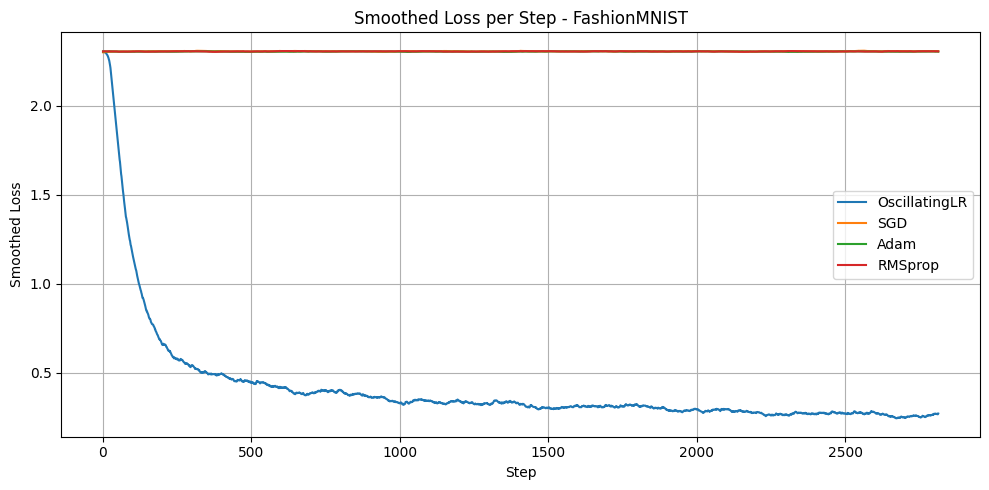

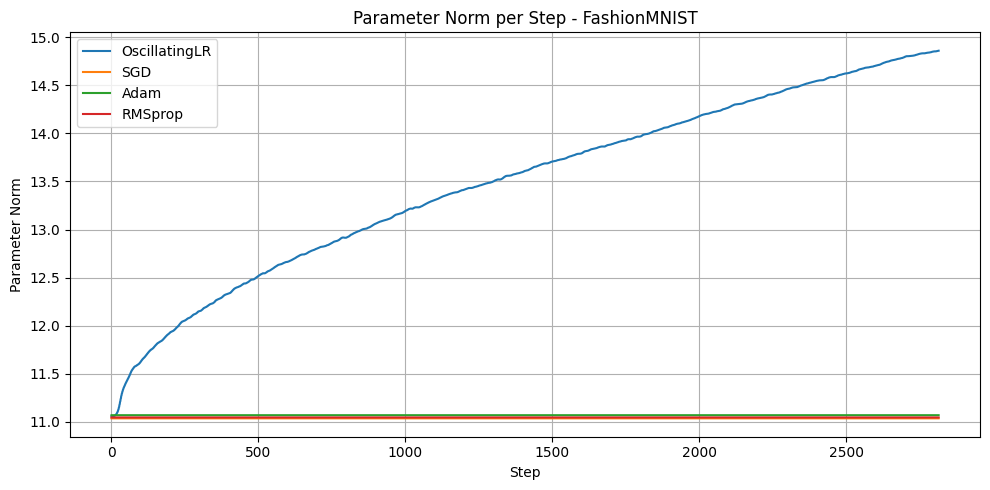

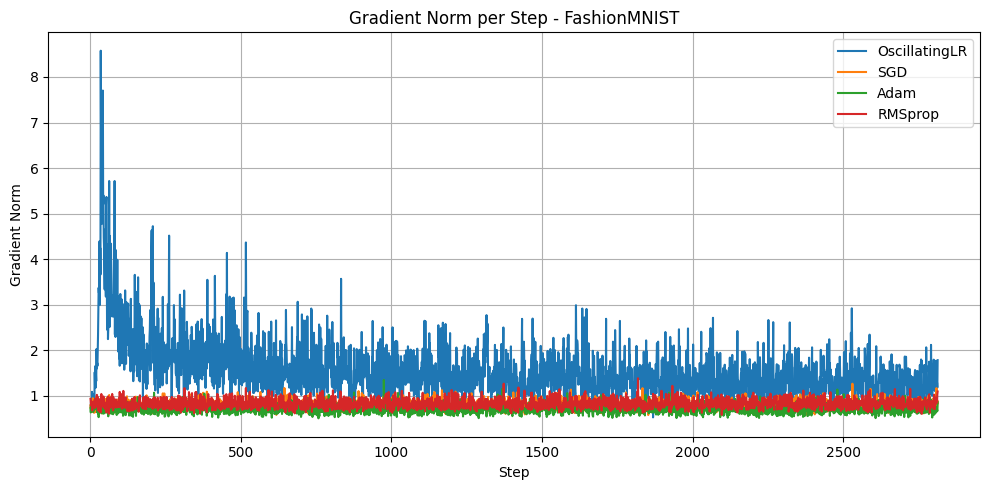

✅ Plots saved: fashionmnist_loss_comparison.png, fashionmnist_paramnorm_comparison.png, fashionmnist_gradnorm_comparison.png


In [ ]:
# ============================================
# Per-step visualization for multiple optimizers on Fashion-MNIST
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------------
# Custom OscillatingLR optimizer
# ----------------------------
class OscillatingLR(torch.optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005, momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1

        # Alternate explicitly every step
        if self.step_count % 2 == 0:
            lr = self.base_lr + self.oscillation_factor
        else:
            lr = self.base_lr - self.oscillation_factor

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity

        # ✅ Print actual LR at every step (for debugging)
        # You can comment this out later


        if closure is not None:
            return closure()

        return lr


# ----------------------------
# Simple CNN model
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# Load Fashion-MNIST dataset
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ----------------------------
# Training function
# ----------------------------
def run_optimizer(optimizer_name, optimizer_class, **opt_params):
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **opt_params)

    logs = {"step": [], "epoch": [], "loss": [], "smoothed": [], "param_norm": [], "grad_norm": []}
    smoothing_alpha = 0.02
    smoothed = None
    step = 0
    num_epochs = 3  # For visualization only — increase for real experiments

    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            step += 1
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            grad_norm = sum(p.grad.norm().item()**2 for p in model.parameters() if p.grad is not None) ** 0.5

            lr = optimizer.step() if isinstance(optimizer, OscillatingLR) else optimizer.param_groups[0]['lr']

            param_norm = sum(p.data.norm().item()**2 for p in model.parameters()) ** 0.5

            smoothed = loss.item() if smoothed is None else smoothing_alpha * loss.item() + (1 - smoothing_alpha) * smoothed

            logs["step"].append(step)
            logs["epoch"].append(epoch + 1)
            logs["loss"].append(loss.item())
            logs["smoothed"].append(smoothed)
            logs["param_norm"].append(param_norm)
            logs["grad_norm"].append(grad_norm)

            if step % 50 == 0:
                print(f"[{optimizer_name}] Step {step:04d} | Epoch {epoch+1} | Loss: {loss.item():.4f} | LR: {lr:.5f}")

    df = pd.DataFrame(logs)
    return df

# ----------------------------
# Run all optimizers
# ----------------------------
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01, "oscillation_factor": 0.005, "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01}),
}

results = {}
for name, (opt_class, opt_params) in optimizers.items():
    print("\n" + "="*70)
    print(f"Training with {name}")
    results[name] = run_optimizer(name, opt_class, **opt_params)

# ----------------------------
# Visualization
# ----------------------------
plt.figure(figsize=(10,5))
for name, df in results.items():
    plt.plot(df['step'], df['smoothed'], label=name)
plt.xlabel("Step")
plt.ylabel("Smoothed Loss")
plt.title("Smoothed Loss per Step - FashionMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fashionmnist_loss_comparison.png")
plt.show()

plt.figure(figsize=(10,5))
for name, df in results.items():
    plt.plot(df['step'], df['param_norm'], label=name)
plt.xlabel("Step")
plt.ylabel("Parameter Norm")
plt.title("Parameter Norm per Step - FashionMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fashionmnist_paramnorm_comparison.png")
plt.show()

plt.figure(figsize=(10,5))
for name, df in results.items():
    plt.plot(df['step'], df['grad_norm'], label=name)
plt.xlabel("Step")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm per Step - FashionMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fashionmnist_gradnorm_comparison.png")
plt.show()

print("✅ Plots saved: fashionmnist_loss_comparison.png, fashionmnist_paramnorm_comparison.png, fashionmnist_gradnorm_comparison.png")


## COVID dataset - Oscillatory LR Covid


✅ Data loaded: (429435, 67)
36810
9203

Training with OscillatingLR
OscillatingLR | Epoch [5/20] | Loss: 0.99991
OscillatingLR | Epoch [10/20] | Loss: 0.94017
OscillatingLR | Epoch [15/20] | Loss: 0.84742
OscillatingLR | Epoch [20/20] | Loss: 0.77181

Training with SGD
SGD | Epoch [5/20] | Loss: 1.04516
SGD | Epoch [10/20] | Loss: 0.93295
SGD | Epoch [15/20] | Loss: 0.82674
SGD | Epoch [20/20] | Loss: 0.73097

Training with Adam
Adam | Epoch [5/20] | Loss: 0.72297
Adam | Epoch [10/20] | Loss: 0.68509
Adam | Epoch [15/20] | Loss: 0.61320
Adam | Epoch [20/20] | Loss: 0.57377

Training with RMSprop
RMSprop | Epoch [5/20] | Loss: 0.92454
RMSprop | Epoch [10/20] | Loss: 0.75320
RMSprop | Epoch [15/20] | Loss: 0.64617
RMSprop | Epoch [20/20] | Loss: 0.62220


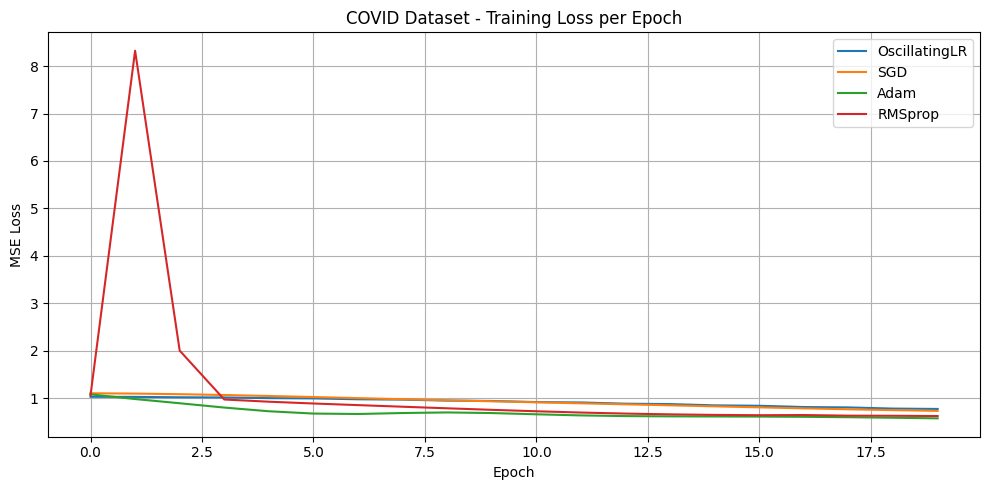


✅ Final RMSE comparison:
       Optimizer     Test RMSE
0  OscillatingLR  68489.347306
1            SGD  67064.644428
2           Adam  60007.952222
3        RMSprop  62698.308382


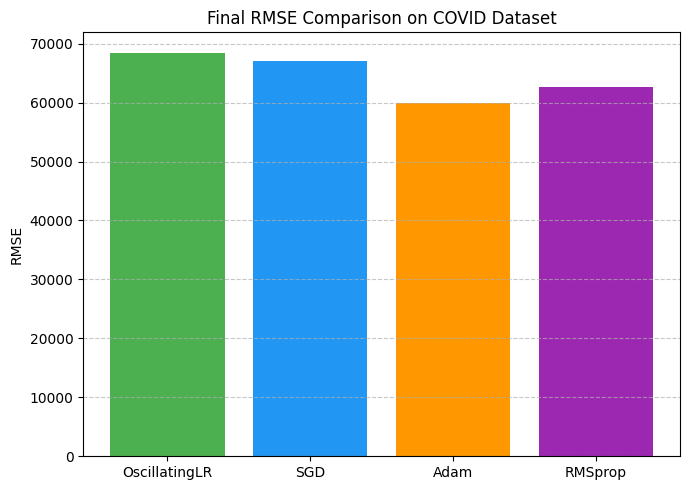

In [1]:
# =====================================================
# OscillatingLR vs SGD vs Adam vs RMSprop on COVID dataset
# =====================================================

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import requests, io

# ----------------------------
# 1. Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
set_seed(42)

# ----------------------------
# 2. Custom OscillatingLR Optimizer
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005, momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        if self.step_count % 2 == 0:
            lr = self.base_lr + self.oscillation_factor
        else:
            lr = self.base_lr - self.oscillation_factor

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity
        if closure is not None:
            return closure()
        return lr

# ----------------------------
# 3. Load COVID dataset (Our World in Data)
# ----------------------------
url = "https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv"
print("Downloading dataset...")
df = pd.read_csv(url)
print("✅ Data loaded:", df.shape)

# Keep only relevant numeric columns
numeric_cols = [
    'new_cases', 'new_deaths', 'reproduction_rate', 'people_vaccinated',
    'population_density', 'median_age', 'gdp_per_capita', 'stringency_index'
]
df = df[numeric_cols].dropna().reset_index(drop=True)

# Define input/output
X = df.drop('new_cases', axis=1).values
y = df['new_cases'].values.reshape(-1, 1)

# Standardize
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# ----------------------------
# 4. Simple MLP model
# ----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# ----------------------------
# 5. Train and evaluate function
# ----------------------------
def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = MLP(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 20
    losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 5 == 0:
            print(f"{optimizer_name} | Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.5f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        rmse = np.sqrt(mean_squared_error(
            scaler_y.inverse_transform(y_test),
            scaler_y.inverse_transform(preds.numpy())
        ))

    return losses, rmse

# ----------------------------
# 6. Run comparisons
# ----------------------------
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01, "oscillation_factor": 0.005, "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01}),
}

results = {}
rmses = {}

for name, (opt_class, opt_params) in optimizers.items():
    print("\n" + "="*60)
    print(f"Training with {name}")
    losses, rmse = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = losses
    rmses[name] = rmse

# ----------------------------
# 7. Visualize results
# ----------------------------
plt.figure(figsize=(10,5))
for name, losses in results.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("COVID Dataset - Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("covid_loss_comparison.png")
plt.show()

# Final RMSE comparison
rmse_df = pd.DataFrame(list(rmses.items()), columns=["Optimizer", "Test RMSE"])
print("\n✅ Final RMSE comparison:")
print(rmse_df)

plt.figure(figsize=(7,5))
plt.bar(rmse_df["Optimizer"], rmse_df["Test RMSE"], color=["#4CAF50","#2196F3","#FF9800","#9C27B0"])
plt.title("Final RMSE Comparison on COVID Dataset")
plt.ylabel("RMSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("covid_rmse_comparison.png")
plt.show()

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 343kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.5MB/s]



OscillatingLR | Epoch [1/10] | Loss: 0.5335
OscillatingLR | Epoch [2/10] | Loss: 0.3188
OscillatingLR | Epoch [3/10] | Loss: 0.2722
OscillatingLR | Epoch [4/10] | Loss: 0.2398
OscillatingLR | Epoch [5/10] | Loss: 0.2164
OscillatingLR | Epoch [6/10] | Loss: 0.1981
OscillatingLR | Epoch [7/10] | Loss: 0.1805
OscillatingLR | Epoch [8/10] | Loss: 0.1646
OscillatingLR | Epoch [9/10] | Loss: 0.1478
OscillatingLR | Epoch [10/10] | Loss: 0.1326
✅ OscillatingLR Test Accuracy: 91.84% | Time: 845.3s

SGD | Epoch [1/10] | Loss: 0.5267
SGD | Epoch [2/10] | Loss: 0.3148
SGD | Epoch [3/10] | Loss: 0.2682
SGD | Epoch [4/10] | Loss: 0.2391
SGD | Epoch [5/10] | Loss: 0.2163
SGD | Epoch [6/10] | Loss: 0.1964
SGD | Epoch [7/10] | Loss: 0.1789
SGD | Epoch [8/10] | Loss: 0.1628
SGD | Epoch [9/10] | Loss: 0.1483
SGD | Epoch [10/10] | Loss: 0.1335
✅ SGD Test Accuracy: 91.93% | Time: 834.7s

Adam | Epoch [1/10] | Loss: 0.5217
Adam | Epoch [2/10] | Loss: 0.3803
Adam | Epoch [3/10] | Loss: 0.3510
Adam | Epoch [

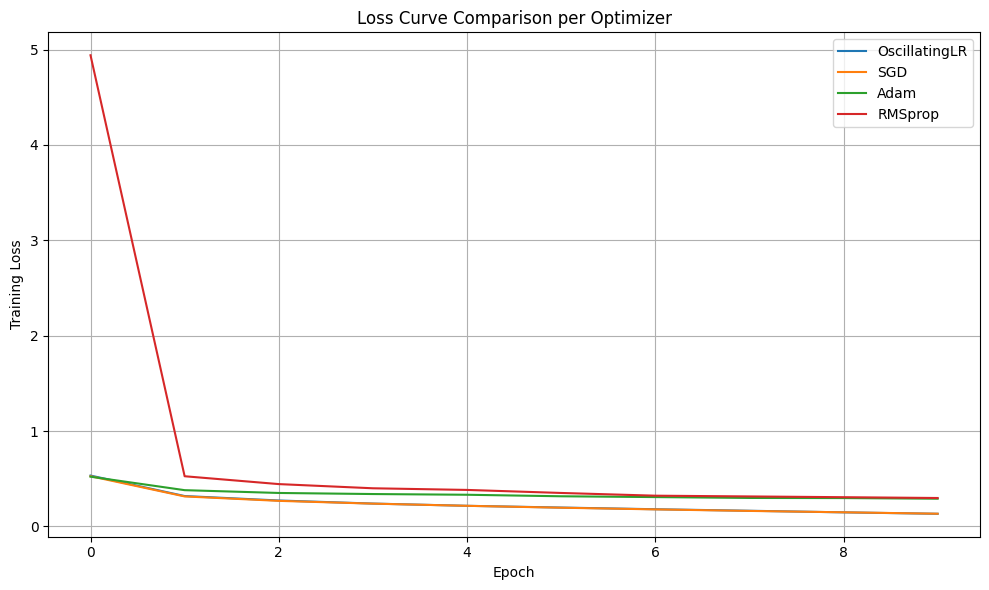

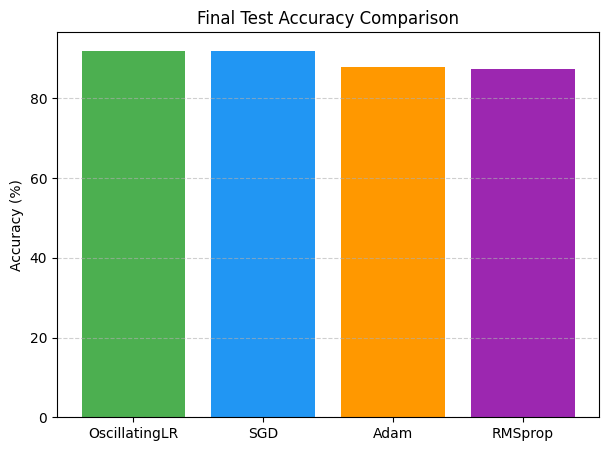

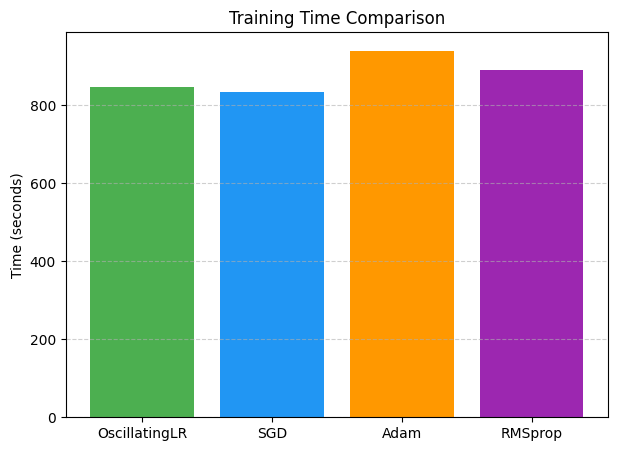


===== FINAL COMPARISON TABLE =====

    Optimizer  Accuracy (%)  Training Time (s)
          SGD         91.93         834.681958
OscillatingLR         91.84         845.328209
         Adam         87.73         939.882354
      RMSprop         87.37         891.129824


In [2]:
# ============================================
# Optimizer Comparison: OscillatingLR vs SGD, Adam, RMSprop
# Author: (Your Name)
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np, random, time, pandas as pd

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------------
# Custom OscillatingLR Optimizer
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005, momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count
        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity
        if closure is not None:
            return closure()
        return lr

# ----------------------------
# CNN Model Definition
# ----------------------------
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# Data Preparation
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Training + Evaluation Function
# ----------------------------
def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = FashionMNISTCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 10
    epoch_losses = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{optimizer_name} | Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    elapsed = time.time() - start_time
    print(f"✅ {optimizer_name} Test Accuracy: {accuracy:.2f}% | Time: {elapsed:.1f}s")
    return accuracy, epoch_losses, elapsed

# ----------------------------
# Run Comparisons
# ----------------------------
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01, "oscillation_factor": 0.005, "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}

results, loss_logs, times = {}, {}, {}

for name, (opt_class, opt_params) in optimizers.items():
    print("\n" + "="*60)
    acc, losses, elapsed = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = acc
    loss_logs[name] = losses
    times[name] = elapsed

# ----------------------------
# Visualization
# ----------------------------
plt.figure(figsize=(10, 6))
for name, losses in loss_logs.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve Comparison per Optimizer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy Comparison Bar Chart
plt.figure(figsize=(7,5))
plt.bar(results.keys(), results.values(), color=['#4CAF50','#2196F3','#FF9800','#9C27B0'])
plt.title("Final Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Training Time Bar Chart
plt.figure(figsize=(7,5))
plt.bar(times.keys(), times.values(), color=['#4CAF50','#2196F3','#FF9800','#9C27B0'])
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------
# Summary Table
# ----------------------------
df = pd.DataFrame({
    "Optimizer": results.keys(),
    "Accuracy (%)": results.values(),
    "Training Time (s)": times.values()
})
df = df.sort_values("Accuracy (%)", ascending=False).reset_index(drop=True)
print("\n===== FINAL COMPARISON TABLE =====\n")
print(df.to_string(index=False))


#Breast Histopathology

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

100%|██████████| 3.10G/3.10G [00:29<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


In [6]:
# ============================================================
# Breast Cancer Detection (Histopathology Images)
# Comparison: OscillatingLR vs SGD vs Adam vs RMSprop
# ============================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# ----------------------------
# 1. Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------------
# 2. Custom OscillatingLR Optimizer
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005, momentum=0.9, decay=0.0005):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.decay = decay
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        decay_factor = 1.0 / (1.0 + self.decay * self.step_count)
        if self.step_count % 2 == 0:
            lr = self.base_lr + self.oscillation_factor * decay_factor
        else:
            lr = self.base_lr - self.oscillation_factor * decay_factor

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity

        return lr

# ----------------------------
# 3. Data loading from your Kaggle path
# ----------------------------
data_dir = "/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define the classes of interest (assuming '0' is benign and '1' is malignant based on common practice)
# You might need to inspect the dataset structure to confirm these labels.
classes_of_interest = ['0', '1']
class_to_idx = {cls: i for i, cls in enumerate(classes_of_interest)}
idx_to_class = {i: cls for i, cls in enumerate(classes_of_interest)}

# Filter the dataset to include only images from the classes of interest
filtered_samples = [(path, class_to_idx[os.path.basename(os.path.dirname(path))])
                    for path, label in full_dataset.samples
                    if os.path.basename(os.path.dirname(path)) in classes_of_interest]

full_dataset.samples = filtered_samples
full_dataset.targets = [s[1] for s in filtered_samples]


# Optionally limit to smaller subset for faster training
subset_size = 8000
if len(full_dataset) > subset_size:
    dataset = torch.utils.data.Subset(full_dataset, np.random.choice(len(full_dataset), subset_size, replace=False))
else:
    dataset = full_dataset


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"✅ Loaded {len(train_dataset)} training and {len(test_dataset)} test images.")

# ----------------------------
# 4. CNN model
# ----------------------------
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ----------------------------
# 5. Training and evaluation
# ----------------------------
def train_and_evaluate(optimizer_name, optimizer_class, **opt_params):
    model = CancerCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **opt_params)
    num_epochs = 20  # increase to 10–20 for better accuracy
    epoch_losses, epoch_accs = [], []

    for epoch in range(10):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        epoch_losses.append(avg_loss)
        epoch_accs.append(accuracy)
        print(f"{optimizer_name} | Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Acc: {accuracy:.2f}%")

    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return epoch_losses, epoch_accs, test_acc

# ----------------------------
# 6. Run comparisons
# ----------------------------
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01, "oscillation_factor": 0.005, "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.001}),
    "RMSprop": (optim.RMSprop, {"lr": 0.001}),
}

results = {}
for name, (opt_class, opt_params) in optimizers.items():
    print("\n" + "="*70)
    print(f"Training with {name}")
    losses, accs, test_acc = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = {"losses": losses, "accs": accs, "test_acc": test_acc}

# ----------------------------
# 7. Visualization
# ----------------------------
plt.figure(figsize=(10,5))
for name in results:
    plt.plot(results[name]["losses"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch - Breast Cancer Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cancer_loss_comparison.png")
plt.show()

plt.figure(figsize=(10,5))
for name in results:
    plt.plot(results[name]["accs"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy per Epoch - Breast Cancer Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cancer_accuracy_comparison.png")
plt.show()

print("\n✅ Final Test Accuracy:")
for name in results:
    print(f"{name}: {results[name]['test_acc']:.2f}%")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/'